<a href="https://colab.research.google.com/github/CsonVass/lpr-image-processing-hw/blob/main/sniper_dict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Only run first time, to set up the environment!

In [1]:
# mount google drive with essential files
from google.colab import drive
drive.mount('/content/drive')
%cd ..

Mounted at /content/drive
/


In [2]:
# install needed modules
!pip install opencv-python
!pip install numpy
!pip install matplotlib
!pip install pillow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageFilter
from google.colab.patches import cv2_imshow

In [4]:
# the class that utilises the pre-trained weights
class LicensePlateDetector:
    def __init__(self, pth_weights: str, pth_cfg: str, pth_classes: str):
        self.net = cv2.dnn.readNet(pth_weights, pth_cfg)
        self.classes = []
        with open(pth_classes, 'r') as f:
            self.classes = f.read().splitlines()

        self.coordinates = []
        self.confidences = []

        self.img = None
        self.roi_image = []
        self.main_plate = None
        
    # detects all the bounding boxes  
    def detect(self, img_path: str):
        orig = cv2.imread(img_path)
        self.img = orig
        img = orig.copy()
        height, width, _ = img.shape
        blob = cv2.dnn.blobFromImage(img, 1 / 255, (416, 416), (0, 0, 0), swapRB=True, crop=False)
        self.net.setInput(blob)
        output_layer_names = self.net.getUnconnectedOutLayersNames()
        layer_outputs = self.net.forward(output_layer_names)
        boxes = []
        confidences = []
        class_ids = []

        for output in layer_outputs:
            for detection in output:
                scores = detection[5:]
                class_id = np.argmax(scores) 
                confidence = scores[class_id]
                if confidence > 0.82:
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = int(center_x - w / 2)
                    y = int(center_y - h / 2)

                    boxes.append([x, y, w, h])
                    confidences.append((float(confidence)))
                    class_ids.append(class_id)
                    
        self.confidences = confidences
        indexes = cv2.dnn.NMSBoxes(boxes, confidences, 0.2, 0.4)

        if len(indexes) > 0:
            for i in indexes.flatten():
                x, y, w, h = boxes[i]
                self.coordinates.append([x, y, w, h])
        return
    
    
    # crops all the detected license plates
    def crop_plate(self):
        for plate in range(len(self.coordinates)):
          x, y, w, h = self.coordinates[plate]
          self.roi_image.append(self.img[y:y + h, x:x + w])
        return

    def crop_main_plate(self):
      main_img_idx = 0
      x, y, w, h = self.coordinates[main_img_idx]
      self.main_plate = self.img[y:y + h, x:x + w]
      for idx in range(len(self.coordinates)):
        if self.confidences[main_img_idx] < self.confidences[idx]:
          x, y, w, h = self.coordinates[plate]
          self.main_plate = self.img[y:y + h, x:x + w]
      return


## Choose the folder where the images are located

In [5]:
# where all the images are located
image_folder = '/content/drive/MyDrive/Colab Notebooks/ALPR/images'

# where the weights, config file and names are located
yolov4_folder = '/content/drive/MyDrive/Colab Notebooks/ALPR/yolov4'

In [6]:
# dictionary for the cropped images
image_dict = {}

# iterate through all images in image folder
for image in os.listdir(image_folder):

  lpd = LicensePlateDetector(
      pth_weights = yolov4_folder + '/yolov4-obj_2000.weights',
      pth_cfg = yolov4_folder + '/yolov4-obj.cfg', 
      pth_classes = yolov4_folder + '/obj.names')
  
  # full path of the image
  image_path = os.path.join(image_folder, image)

  # detect license plate
  lpd.detect(image_path)

  # crop plate and show cropped plate
  lpd.crop_plate()

  # create new key in dictionary for image
  image_dict.update({
      image: []
      })

 # iterate through all license plates in one image
  for plate in lpd.roi_image:
    
    im = Image.fromarray(plate)
    
    # scale up
    size = 416, int((416 / im.size[0]) * im.size[1])
    im = im.resize(size)

    # append license plate to image in dictionary
    image_dict[image].append(im)
    #im.save('/content/drive/MyDrive/Colab Notebooks/ALPR/plates/' + image )

print(image_dict)


{'29424b7a1926ec4e.jpg': [<PIL.Image.Image image mode=RGB size=416x168 at 0x7F5DBD7F0730>], '18666381.jpg': [<PIL.Image.Image image mode=RGB size=416x290 at 0x7F5DCE62EE80>], '18664994.jpg': [<PIL.Image.Image image mode=RGB size=416x105 at 0x7F5DBD7F0B50>], 'RYX-928_h.jpg': [<PIL.Image.Image image mode=RGB size=416x263 at 0x7F5DBD7F0520>, <PIL.Image.Image image mode=RGB size=416x101 at 0x7F5DBD7F0700>], 'SWS-448_h.jpg': [<PIL.Image.Image image mode=RGB size=416x247 at 0x7F5DBD794DC0>], '316476175_650984866763427_8310885032851288955_n.jpg': [<PIL.Image.Image image mode=RGB size=416x232 at 0x7F5DBD794F40>], '20434076.jpg': [<PIL.Image.Image image mode=RGB size=416x217 at 0x7F5DBD794F70>, <PIL.Image.Image image mode=RGB size=416x159 at 0x7F5DBD794760>], '20434135.jpg': [<PIL.Image.Image image mode=RGB size=416x110 at 0x7F5DBD794EB0>, <PIL.Image.Image image mode=RGB size=416x122 at 0x7F5DBD794D30>], '20430001.jpg': [<PIL.Image.Image image mode=RGB size=416x90 at 0x7F5DCABD3490>], '20429684

file: 29424b7a1926ec4e.jpg


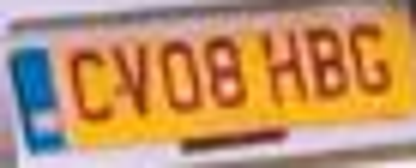

file: 18666381.jpg


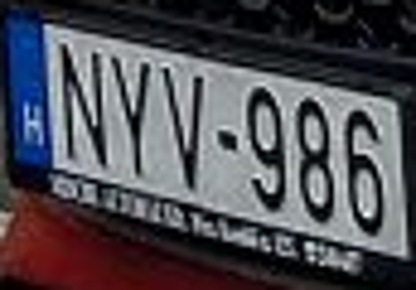

file: 18664994.jpg


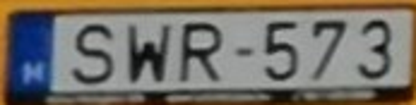

file: RYX-928_h.jpg


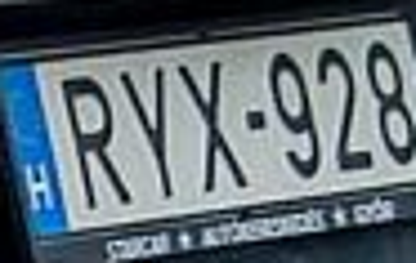

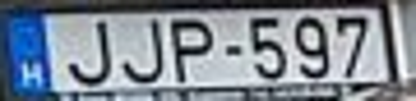

file: SWS-448_h.jpg


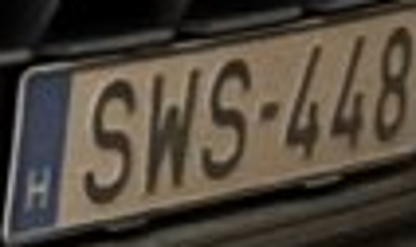

file: 316476175_650984866763427_8310885032851288955_n.jpg


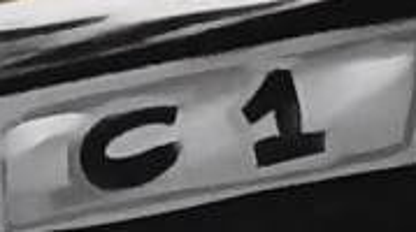

file: 20434076.jpg


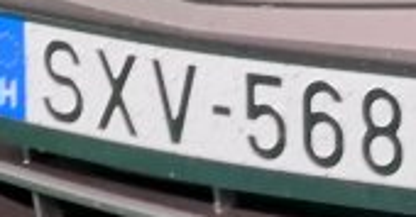

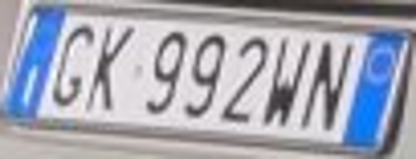

file: 20434135.jpg


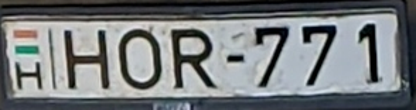

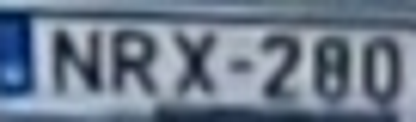

file: 20430001.jpg


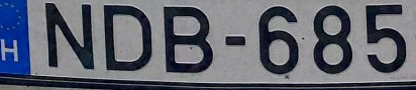

file: 20429684.jpg


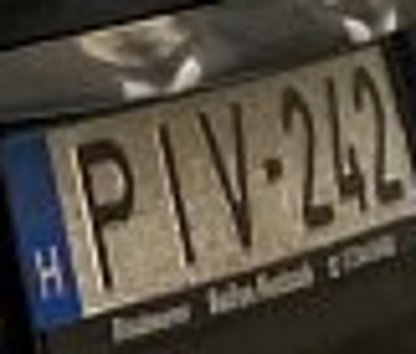

In [7]:
# iterate threough all images and print license plates
for key, value in image_dict.items():
  print("file: " + key, end="\n")
  for img in range(len(value)):
    cv2_imshow(np.array(image_dict[key][img]))